In [15]:
import numpy as np
import pandas as pd
import iminuit
import sys
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from scipy.integrate import quad

from scipy import stats
from scipy.stats import cauchy as lorentz
from scipy.special import voigt_profile as voigt
from scipy.special import erf, erfc

In [2]:
#define the theoretical model
# defining the theoretical model
normalize = lambda a: a / np.sum(a)

a_ij = [5898.853, 5897.867, 5894.829, 5896.532, 5899.417, 5902.712, 5887.743, 5886.495]
aw_ij = [1.715, 2.043, 4.499, 2.663, 0.969, 1.5528, 2.361, 4.216] # FWHM
ai_ij = [0.790, 0.264, 0.068, 0.096, 0.007, 0.0106, 0.372, 0.100]
b_ij = [6490.89, 6486.31, 6477.73, 6490.06, 6488.83]
bw_ij = [1.83, 9.40, 13.22, 1.81, 2.81]
bi_ij = [0.608, 0.109, 0.077, 0.397, 0.176]

skewed_lorentz = np.vectorize(lambda x, s, l: quad(lambda x, theta=x, s=s, l=l: skewed_lorentz_ft(x, theta, s, l), 0, np.inf)[0])

K_alpha_pdf_esc = np.vectorize(lambda x, sigma, esc_k: np.sum([ai_ij[i]*voigt(x - a_ij[i], sigma, aw_ij[i]/2)*erfc(esc_k*(x - a_ij[i]))/voigt(0, sigma, aw_ij[i]/2) for i in range(len(a_ij))])/np.sum([ai_ij[i]/voigt(0, sigma, aw_ij[i]/2) for i in range(len(a_ij))]))
K_beta_pdf_esc = np.vectorize(lambda x, sigma, esc_k: np.sum([bi_ij[i]*voigt(x - b_ij[i], sigma, bw_ij[i]/2)*erfc(esc_k*(x - b_ij[i]))/voigt(0, sigma, bw_ij[i]/2) for i in range(len(b_ij))])/np.sum([bi_ij[i]/voigt(0, sigma, bw_ij[i]/2) for i in range(len(b_ij))]))

## 0. raw data for traces
Cases below should be throw:  

Sensor events: sharp peak with rapid drop, caused by interactions directly in the paramagnetic sensor (instead of the absorber)

Pile-up events: trace on top of a trace, two interactions shortly after another, before the temperature could return to the equilibrium

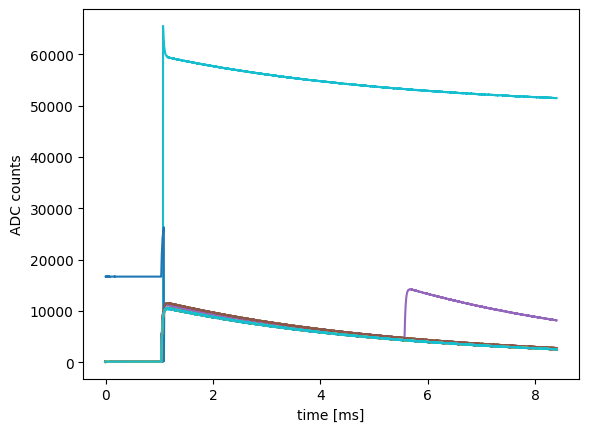

In [4]:
traces = pd.read_csv('traces.csv', header=None)

fig, ax = plt.subplots()
for j in range(100):
    plt.plot([i/32768*8.4 for i in range(len(traces.iloc[j]))], traces.iloc[j])
plt.xlabel(r"time [ms]")
plt.ylabel("ADC counts")
plt.show()

In [5]:
df = pd.read_csv('rqs.csv')
print(df)

            time  channel  trace_index  temperature  mean_baseline  \
0         295986        0            1      32750.8      128.96450   
1         401300        0            2      32750.3      131.35750   
2         866004        0            3      32751.0      132.40300   
3        1039604        0            4      32749.6      128.61825   
4        1539099        0            5      32750.1      128.21525   
...          ...      ...          ...          ...            ...   
7995  2945388927        0         8649      32751.7      132.33725   
7996  2945427803        0         8650      32752.3      132.64750   
7997  2945796482        0         8651      32749.8      131.13550   
7998  2946180772        0         8652      32751.7      133.17700   
7999  2946350236        0         8653      32750.5      134.31900   

      std_baseline         mean          std            A  rise_time  ...  \
0         5.505519  4929.440704  2810.464237  10407.03550   0.000026  ...   
1    

### Why Voigt?
- In X-ray spectroscopy, the theoretical "natural line shape" is Lorentzian (due to the finite lifetime of atomic states).
Real detectors and Doppler broadening introduce additional Gaussian-like broadening.  
- Hence, convolving Lorentzian and Gaussian gives a Voigt profile, a more realistic model of the observed line shape.

### Why `erfc`?
- Some fraction of the energy (phonons) can escape the detector before being fully measured, causing a tail on the low-energy side. Multiplying by `erfc` captures this tail suppression.


## 1. Baseline offset cut
First cut been applied on the data entry baseline offset to remove the bad events discussed in the previous section. A larger offset often indicates the detector was not at the stable reference temperature at the time of the event.

In [6]:
#preselection: set a cut on baseline offset
mask_baseline_offset = (df['baseline_offset'] > 129) & (df['baseline_offset'] < 133)
mask_sel = mask_baseline_offset

cut efficiency:  0.6145


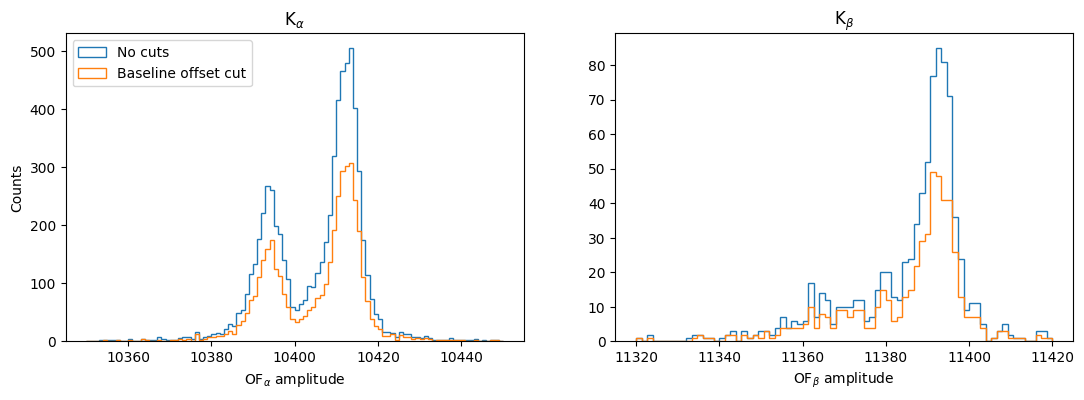

In [7]:
binning_alpha = np.linspace(1.035e4, 1.045e4, 101)
binning_beta = np.linspace(1.132e4, 1.142e4, 76)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

plt.sca(axs[0])
plt.hist(df.OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C0', label='No cuts')
#plt.hist(df.OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C1', label='All cuts')
plt.hist(df[mask_baseline_offset].OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C1', label='Baseline offset cut')
plt.xlabel(r'OF$_\alpha$ amplitude'), plt.ylabel('Counts'), plt.legend(loc='upper left'), plt.title(r'K$_\alpha$')

plt.sca(axs[1])
plt.hist(df.OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C0', label='No cuts')
#plt.hist(df.OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C1', label='All cuts')
plt.hist(df[mask_baseline_offset].OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C1', label='Baseline offset cut')
plt.xlabel(r'OF$_\beta$ amplitude'), plt.title(r'K$_\beta$')

print("cut efficiency: ",len(df[mask_baseline_offset].OF_ampl_0)/len(df.OF_ampl_0));


## 2. Time Correction (“Drift Correction”)

Over the **50-minute** run, the amplitude of pulses (“OF amplitudes”) drifts (likely from a slow temperature or electronics change).

### Binning, Mean Calculation, and Polynomial Fit
1. **Bin in time**: use `stats.binned_statistic` to split events into time bins and compute the mean OF amplitude in each bin.  
2. **Fit a linear function** (first-order polynomial) to that mean amplitude vs. time.  
3. **Correct each event** by
   $$
   A_{\text{cOF}} \;=\; A_{\text{original}} \;\times\; \frac{\mu_{\text{overall}}}{A_{\text{fit}}(t)}
   $$
   where 
   - $A_{\text{original}}$ is the measured amplitude,  
   - $A_{\text{fit}}(t)$ is the fitted amplitude at the event’s time, and  
   - $\mu_{\text{overall}}$ is the average amplitude across the time bins.

### Why do we do this?
- We want all events to be on a consistent amplitude scale, as if no drift had occurred.

---

In [8]:
# Assume df is a DataFrame with columns:
#   df.time, df.OF_ampl_0, df.OF_ampl_1, etc.
# and mask_sel is a boolean mask for your "good events".

# Let's define the time bins
time_bins = np.linspace(0, 3e9, 21)

####################################
# 1) Correct OF_alpha (Kα range)
####################################
# mask_peak: select area near Kα line
mask_peak = (df.OF_ampl_0 > 1.036e4) & (df.OF_ampl_0 < 1.044e4)

# Compute the mean amplitude for each time bin
mean = stats.binned_statistic(
    df[mask_sel & mask_peak].time,
    df[mask_sel & mask_peak].OF_ampl_0,
    'mean',
    bins=time_bins
)

# Extract the mean amplitudes and time bin centers
mu = mean.statistic
ts = 0.5 * (mean.bin_edges[1:] + mean.bin_edges[:-1])

# Filter out invalid bins
mask_1 = (mu > 1e4)
mu_1 = mu[mask_1]
ts_1 = ts[mask_1]

# Fit a linear polynomial to the binned means
corr_OF_ampl = np.poly1d(np.polyfit(ts_1, mu_1, 1))

# Compute a global mean
mu_mean = np.mean(mu_1)

# Apply the correction to df.OF_ampl_0
df['cOF_ampl_0'] = df.OF_ampl_0 / corr_OF_ampl(df.time) * mu_mean

####################################
# 2) Correct OF_beta (Kβ range)
####################################
mask_peak = (df.OF_ampl_1 > 1.036e4) & (df.OF_ampl_1 < 1.044e4)
mean = stats.binned_statistic(
    df[mask_sel & mask_peak].time,
    df[mask_sel & mask_peak].OF_ampl_1,
    'mean',
    bins=time_bins
)

mu = mean.statistic
ts = 0.5 * (mean.bin_edges[1:] + mean.bin_edges[:-1])

mask_1 = (mu > 1e4)
mu_1 = mu[mask_1]
ts_1 = ts[mask_1]

corr_OF_ampl = np.poly1d(np.polyfit(ts_1, mu_1, 1))
mu_mean = np.mean(mu_1)

df['cOF_ampl_1'] = df.OF_ampl_1 / corr_OF_ampl(df.time) * mu_mean

####################################
# 3) Filter data in cOF space
####################################
binning_alpha = np.linspace(1.035e4, 1.045e4, 101)
binning_beta  = np.linspace(1.132e4, 1.142e4, 76)

mask_fit = (
    mask_sel
    & (
       ((df.cOF_ampl_0 > binning_alpha[0]) & (df.cOF_ampl_0 < binning_alpha[-1]))
       | ((df.cOF_ampl_0 > binning_beta[0]) & (df.cOF_ampl_0 < binning_beta[-1]))
      )
)

df = df[mask_fit].copy()




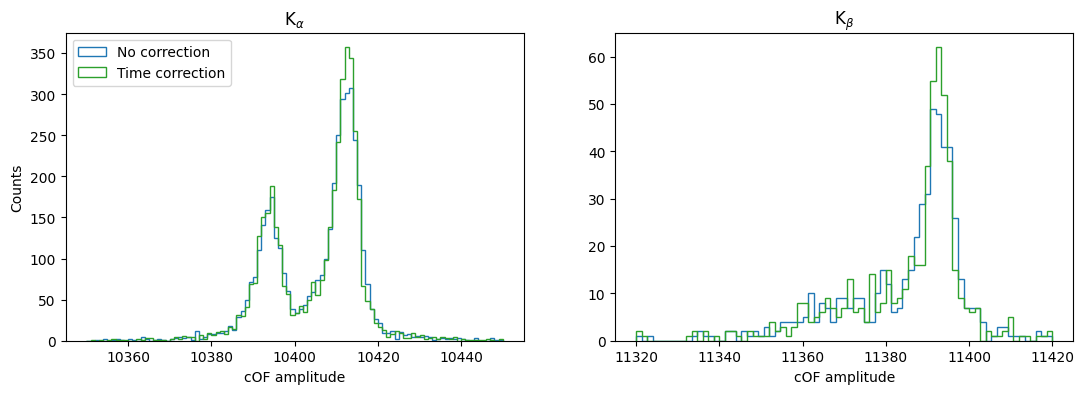

In [11]:
# Histograms of the cOF at K_alpha and K_beta
binning_alpha = np.linspace(1.035e4, 1.045e4, 101)
binning_beta = np.linspace(1.132e4, 1.142e4, 76)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))

plt.sca(axs[0])
plt.hist(df.OF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C0', label='No correction')
plt.hist(df.cOF_ampl_0, bins=binning_alpha, histtype='step', lw=2., edgecolor='C2', label='Time correction')
plt.xlabel(r'cOF amplitude'), plt.ylabel('Counts'), plt.legend(loc='upper left'), plt.title(r'K$_\alpha$')

plt.sca(axs[1])
plt.hist(df.OF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C0', label='No correction')
plt.hist(df.cOF_ampl_1, bins=binning_beta, histtype='step', lw=2., edgecolor='C2', label='Time correction')
plt.xlabel(r'cOF amplitude'), plt.title(r'K$_\beta$');

## 5. Combining Corrected Amplitudes

We have **two optimum filters**:
- $\text{OF}_\alpha$ (optimized for K$\alpha$)  
- $\text{OF}_\beta$ (optimized for K\$\beta$)

After time-correcting both, the code:
- Uses `cOF_ampl_0` (K$\alpha$) for events near the K$\alpha$ peak region.  
- Uses `cOF_ampl_1` (K$\beta$) for events near the K$\beta$ peak.  
- Combines into one column `df['cOF_ampl']` for further fitting.

---

In [12]:
####################################
# 4) Combine cOF_ampl_0 and cOF_ampl_1
####################################
df['cOF_ampl'] = np.zeros_like(df.cOF_ampl_0)

# Use cOF_ampl_0 for events in alpha range
alpha_mask = (df.cOF_ampl_0 > binning_alpha[0]) & (df.cOF_ampl_0 < binning_alpha[-1])
df.loc[alpha_mask, 'cOF_ampl'] = df.loc[alpha_mask, 'cOF_ampl_0']

# Use cOF_ampl_1 for events in beta range
beta_mask = (df.cOF_ampl_0 > binning_beta[0]) & (df.cOF_ampl_0 < binning_beta[-1])
df.loc[beta_mask, 'cOF_ampl']  = df.loc[beta_mask, 'cOF_ampl_1']

# Now df['cOF_ampl'] holds the corrected amplitude for each event
# at either the Kα or Kβ region, depending on the event.

## 6. Energy Calibration

We want to relate the corrected OF amplitude $A_{\text{cOF}}$ to the true X-ray energy $E$.

1. **Parametric Model**  
   A quadratic calibration:
   $$
   E \;=\; p_1 \, A_{\text{cOF}}^2 \;+\; p_2 \, A_{\text{cOF}}
   $$
   In the code, these are `E_2`, `E_1`, `E_0`.

2. **Binned $\chi^2$ Fit**  
   - We take the distribution of `cOF_ampl` near the K$\alpha$ line, convert it to energy with our guessed parameters, and compare to the theoretical Voigt + tail model.  
   - The code calculates a $\chi^2$ between **observed** and **model** histograms.  
   - `iminuit` optimizes parameters ($\sigma_0, \text{esc}_k,\dots$) to minimize $\chi^2$.

---

In [16]:
#calculates the chi2 value
def chi2(hist_obs, hist_model, sigma):
    return np.sum((hist_obs - hist_model)**2/sigma**2)

#the fit function used to model the K_alpha line
def model_alpha(x, mu):
    A, E_2, E_1, E_0, sigma_0, esc_k = mu
    E = E_2 * x**2 + E_1 * x + E_0
    return ka * K_alpha_pdf_esc(E, sigma_0, esc_k)

#construct the histogram from the observed data
def get_hist_obs(Es, binning):
    hist_obs, bin_edges = np.histogram(Es, bins=binning)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    return bin_centers, hist_obs

#return the fit function with the correct binning for the K_alpha line
def get_hist_model(binning, ka, sigma_0, esc_k, c):
    bin_centers = 0.5 * (binning[:-1] + binning[1:])
    return bin_centers, ka * K_alpha_pdf_esc(bin_centers, sigma_0, esc_k) + c

#return the fit function with the correct binning for the K_beta line
def get_hist_model_beta(binning, ka, sigma_0, esc_k, c):
    bin_centers = 0.5 * (binning[:-1] + binning[1:])
    return bin_centers, K_beta_pdf_esc(bin_centers, sigma_0, esc_k) + c

#perform the binned chi2 fit at the K_alpha line
def fit_model_alpha(obs, initial_values, binning, empty=False):
    
    def _minimize_function(x, ka, E_2, E_1, E_0, sigma_0, esc_k, c, binning=binning):
        Es = E_2 * x**2 + E_1 * x + E_0
        binning = np.linspace(*binning)
        E_binning = E_2 * binning**2 + E_1 * binning + E_0
        bin_centers, hist_obs = get_hist_obs(Es, E_binning)
        _, hist_model = get_hist_model(E_binning, ka, sigma_0, esc_k, c)
        return chi2(hist_obs, hist_model, np.sqrt(hist_obs))
    
    func = lambda ka, E_2, E_1, E_0, sigma_0, esc_k, c: _minimize_function(obs, ka, E_2, E_1, E_0, sigma_0, esc_k, c, binning)
    m = iminuit.Minuit(func, **initial_values)
    if not empty:
        m.fixed["ka"] = False
        m.fixed["sigma_0"] = False
        m.fixed["E_2"] = False
        m.fixed["E_1"] = False
        m.fixed["E_0"] = True
        m.fixed["esc_k"] = False
        m.fixed["c"] = True

        m.simplex().migrad()
    
    return m
#for K_alpha, plot the fit
#for K_beta, perform an amplitude fit while using values from the K_alpha fit for the other parameters, then plot the fit
def plot_spectrum_fit(df, model, Kline='alpha', ADC_bins=None, E_bins=None):
    
    ADC_to_E = lambda x: model.values['E_2'] * x**2 + model.values['E_1'] * x + model.values['E_0']
    if ADC_bins == None:
        binning = np.linspace(*E_bins)
    else:
        binning = ADC_to_E(np.linspace(*ADC_bins))

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    plt.subplots_adjust(hspace=0.05)

    plt.sca(ax1)
    hist, bin_edges = np.histogram(ADC_to_E(df.cOF_ampl), bins=binning)
    bin_centers = 0.5 * (binning[:-1] + binning[1:])
    plt.hist(ADC_to_E(df.cOF_ampl), bins=binning, histtype='step', label='data')
    plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), ls='None', c='C0')

    get_model = get_hist_model_beta if Kline == 'beta' else get_hist_model
    bin_centers_model, y_model = get_model(binning, model.values['ka'], model.values['sigma_0'], model.values['esc_k'], model.values['c'])
    if Kline == 'beta':
        m_beta = iminuit.Minuit(lambda a: chi2(hist, a * y_model, np.sqrt(hist)), a = 1e2)
        m_beta.simplex().migrad()
        y_model = m_beta.values['a'] * y_model
    Es = np.linspace(binning[0], binning[-1], 1001)
    bin_centers_model, y_model_plot = get_model(Es, model.values['ka'], model.values['sigma_0'], model.values['esc_k'], model.values['c'])
    y_model_plot = m_beta.values['a'] * y_model_plot if Kline == 'beta' else y_model_plot
    plt.plot(bin_centers_model, y_model_plot, label='fit')
    plt.xlim(binning[0], binning[-1]);
    plt.ylabel('Counts')
    plt.legend()

    plt.sca(ax2)
    residuals = hist - y_model
    plt.axhline(0, color='xkcd:black', lw=0.5, ls='--')
    plt.scatter(bin_centers, residuals / np.sqrt(hist), s=2.)
    plt.ylim(-5, 5)
    plt.ylabel(r'Res / $\sigma$'), plt.xlabel('Energy [eV]')
    if Kline == 'beta':
        return m_beta

In [17]:
# the initial values for the fit, determined through a lot of testing
# should not be changed
initial_values = {}
initial_values['esc_k'] = 0.015
initial_values['ka'] = 750
initial_values['E_2'] = 3.26315e-06
initial_values['E_1'] = 0.532509
initial_values['E_0'] = 0.
initial_values['sigma_0'] = 0.53
initial_values['c'] = 0
alpha_bins = (10_380, 10_422, 131)

m = fit_model_alpha(df.cOF_ampl, initial_values, alpha_bins)
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 196.3                      │              Nfcn = 115              │
│ EDM = 0.000191 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ka      │    800    │    13     │            │            │         │         │       │
│ 1 │ E_2     │ 3.263e-6  │ 0.009e-6  │            │            │         │         │       │
│ 2 │ E_1     │ 532.51e-3 │  0.09e-3  │            │            │         │         │       │
│ 3 │ E_0     │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ sigma_0 │   0.53    │   0.06    │            │            │         │         │       │
│ 5 │ esc_k   │   0.023   │   0.010   │            │            │         │         │       │
│ 6 │ c       │    0.0    │    0.1    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │            ka           E_2           E_1           E_0       sigma_0         esc_k             c │
├─────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│      ka │           169 4.30945814e-9    -41.744e-6             0        -0.019     -11.69e-3             0 │
│     E_2 │ 4.30945814e-9      7.31e-17   -759.78e-15             0   5.57442e-12  -1.93447e-12             0 │
│     E_1 │    -41.744e-6   -759.78e-15      7.92e-09          0e-9        -28e-9        -10e-9          0e-9 │
│     E_0 │             0             0          0e-9             0         0.000             0             0 │
│ sigma_0 │        -0.019   5.57442e-12        -28e-9         0.000       0.00397       0.10e-3         0.000 │
│   esc_k │     -11.69e-3  -1.93447e-12        -10e-9             0       0.10e-3      0.000102             0 │
│       c │             0             0          0e-9             0         0.000             0             0 │
└─────────┴───────────────────────────────────────────────────────────────────────────────────────────────────┘

/var/folders/y6/2zvmjscx2s18w96j7qx32nnr0000gn/T/ipykernel_40603/3076644026.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_spectrum_fit(df[mask_fit], m, ADC_bins=alpha_bins)


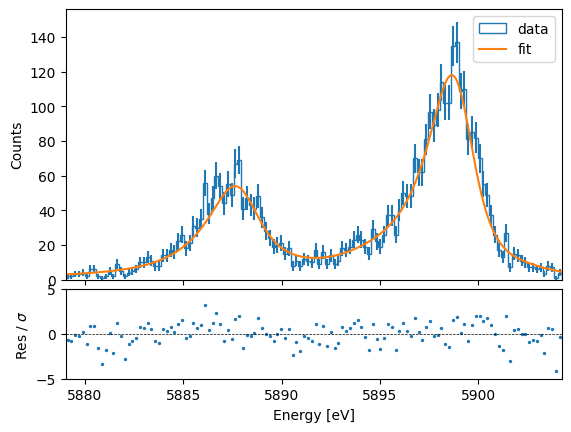

In [18]:
plot_spectrum_fit(df[mask_fit], m, ADC_bins=alpha_bins)

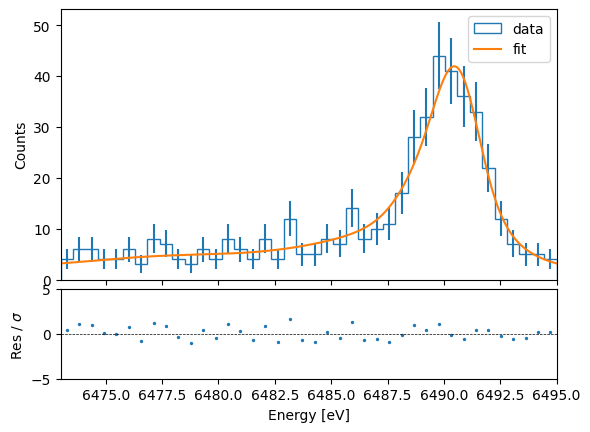

In [19]:
mb = plot_spectrum_fit(df, m, Kline='beta', E_bins=(6473, 6495, 41))

## 7. Extracting Detector Resolution

From the fit, $\sigma_0$ is the Gaussian width (in eV). The **Full-Width at Half Maximum** (FWHM) for a Gaussian is
$$
\mathrm{FWHM} \;=\; 2 \,\sqrt{2\,\ln(2)}\;\sigma.
$$
Example:
```python
fwhm = m.values['sigma_0'] * 2 * np.sqrt(2 * np.log(2))  
fwhm_err = m.errors['sigma_0'] * 2 * np.sqrt(2 * np.log(2))  
print(f'FWHM: ({fwhm:.3f} +- {fwhm_err:.3f}) eV')  
```

In [16]:
# Your code ...
fwhm = m.values['sigma_0'] * 2 * np.sqrt(2 * np.log(2))
fwhm_err = m.errors['sigma_0'] * 2 * np.sqrt(2 * np.log(2))
print(f'FWHM: ({fwhm:.3f} +- {fwhm_err:.3f}) eV')

FWHM: (1.245 +- 0.148) eV


## 8. Reduced $\chi^2$ and Fit Quality

- The total \(\chi^2\) value is stored in `m.fval`.
- The **degrees of freedom** (\(\mathrm{ndof}\)) is usually computed as:
  
  $$
  \mathrm{ndof} = N_{\text{bins}} \;-\; 1 \;-\; N_{\text{parameters}}.
  $$
  
- The **reduced** $\chi^2$, often written $\chi^2_\nu$, is:
  
  $$
  \chi^2_\nu \;=\; \frac{\chi^2}{\mathrm{ndof}}.
  $$
  
- As a rule of thumb:
  - If $\chi^2_\nu \approx 1$, the fit is reasonable.
  - If $\chi^2_\nu \gg 1$, the model may be inadequate or errors are underestimated.
  - If $\chi^2_\nu \ll 1$, the errors might be overestimated or the model is overfitting.

### Example in Code

```python
alpha_chi2 = m.fval
alpha_ndof = alpha_bins[-1] - 1 - 5
alpha_reduced_chi2 = alpha_chi2 / alpha_ndof

beta_chi2 = mb.fval
beta_ndof = 41 - 1 - 5
beta_reduced_chi2 = beta_chi2 / beta_ndof


In [19]:
m.fval / (alpha_bins[-1] - 1 - 5), mb.fval/(41-1-5)

(1.5702291250223388, 0.6328554382949737)